### Introduction

This project aims to develop an image classification algorithm utilizing a neural network.
The data is sourced from the CIFAR10 dataset which in itself is a subset of 50000 labeled images taken out of the 80 million tiny images dataset colected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.
Details of this dataset are described in the following report: \
Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.

In [18]:
from PIL import Image
from io import BytesIO
import os
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras
import keras_tuner
from keras import layers, regularizers
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping, TensorBoard

# Data loading and preprocessing

## Load Data

In [4]:
(train_img, train_labels), (test_img, test_labels) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


## Trim dataset

In [5]:
print('train_img: ' + str(train_img.shape))
print('train_labels: ' + str(train_labels.shape))
print('test_img:  '  + str(test_img.shape))
print('test_labels:  '  + str(test_labels.shape))

train_img: (50000, 32, 32, 3)
train_labels: (50000, 1)
test_img:  (10000, 32, 32, 3)
test_labels:  (10000, 1)


In [6]:
train_img = train_img[:10000]
test_img = test_img[:1000]
train_labels = train_labels[:10000]
test_labels = test_labels[:1000]

## Show a few images

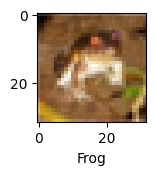

[6]


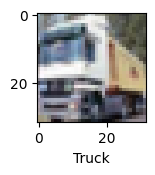

[9]


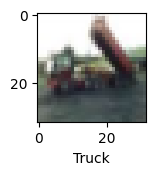

[9]


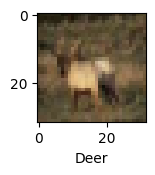

[4]


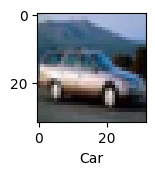

[1]


In [7]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
for i in range(5):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_img[i], cmap=plt.get_cmap('gray'))
  plt.xlabel(classes[train_labels[i][0]])
  plt.show()
  print(train_labels[i])

## Flatten data

In [8]:
train_img = train_img.reshape(train_img.shape[0],-1)
test_img = test_img.reshape(test_img.shape[0],-1)

In [9]:
print('train_img: ' + str(train_img.shape))
print('train_labels: ' + str(train_labels.shape))
print('test_img:  '  + str(test_img.shape))
print('test_labels:  '  + str(test_labels.shape))

train_img: (10000, 3072)
train_labels: (10000, 1)
test_img:  (1000, 3072)
test_labels:  (1000, 1)


## Normalize data

In [10]:
train_img_norm = train_img/255.0
test_img_norm = test_img/255.0

In [11]:
print('train_img: ' + str(train_img_norm.shape))
print('train_labels: ' + str(train_labels.shape))
print('test_img:  '  + str(test_img_norm.shape))
print('test_labels:  '  + str(test_labels.shape))

train_img: (10000, 3072)
train_labels: (10000, 1)
test_img:  (1000, 3072)
test_labels:  (1000, 1)


# Begin Neural Network

In [12]:
def define_model(units, num_layers, activation, lr, l2):
    model_layers = [
        layers.Dense(units, activation=activation, kernel_regularizer=regularizers.L2(l2=l2), kernel_initializer=keras.initializers.HeNormal())
        ] * num_layers
    model_layers += [layers.Dense(10)]
    model = keras.Sequential(model_layers)
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
    return model

In [13]:
def build_model(hp):
    units = hp.Choice("units", [256, 512])
    activation = "relu"
    lr = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
    l2 = hp.Float("l2", min_value=1e-5, max_value=1e-1, sampling="log")
    num_layers = hp.Choice("num_layers", [2, 3, 4])
    model = define_model(units=units, num_layers=num_layers, activation=activation, lr=lr, l2=l2)
    return model

Mount drive

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Initialize Tuner

In [20]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=15,
    executions_per_trial=1,
    overwrite=False,
    directory="/content/drive/MyDrive/models/classif1",
)

Reloading Tuner from /content/drive/MyDrive/models/classif1/untitled_project/tuner0.json


In [24]:
callbacks = [EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, start_from_epoch=4)]

In [27]:
tuner.search(
    train_img,
    train_labels,
    epochs=20,
    verbose=1,
    validation_data=(test_img, test_labels),
    callbacks=callbacks
)

In [26]:
tuner.results_summary(5)

Results summary
Results in /content/drive/MyDrive/models/classif1/untitled_project
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 3 summary
Hyperparameters:
units: 512
lr: 0.00033302053540962636
l2: 0.00011647744885988285
num_layers: 3
Score: 1.7328635454177856

Trial 7 summary
Hyperparameters:
units: 256
lr: 1.3529237662984049e-05
l2: 2.607982203880015e-05
num_layers: 2
Score: 1.847999095916748

Trial 1 summary
Hyperparameters:
units: 256
lr: 0.0031528006260469975
l2: 0.0001597324043783155
num_layers: 3
Score: 1.863990068435669

Trial 4 summary
Hyperparameters:
units: 256
lr: 0.009473033897902664
l2: 0.00014456772808282126
num_layers: 4
Score: 2.0784666538238525

Trial 2 summary
Hyperparameters:
units: 256
lr: 0.005930714988257274
l2: 0.00018386429549433264
num_layers: 2
Score: 2.3014602661132812


Best model is 3, use it to create a confusion matrix

In [28]:
import json
from sklearn.metrics import confusion_matrix

trial_num = "3"
with open(f"/content/drive/MyDrive/models/classif1/untitled_project/trial_{trial_num}/trial.json", "r") as f:
    trial = json.load(f)
hp = trial["hyperparameters"]["values"]
model = define_model(units=hp["units"], num_layers=hp["num_layers"], activation="relu", lr=hp["lr"],
                     l2=hp["l2"])
model.load_weights(f"/content/drive/MyDrive/models/classif1/untitled_project/trial_{trial_num}/checkpoint")

In [29]:
y_pred = np.argmax(model.predict(test_img_norm), axis=1)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

32/32 [==============================] - 2s 9ms/step
[[27  0 21  2  5  1  3  5 28 11]
 [ 3 24  4  2  2  1  1  8 11 33]
 [ 7  1 44  5 13  4 13  6  6  1]
 [ 3  1 18 23  7 11 15 10  3 12]
 [ 7  1 26  2 19  2 15 10  3  5]
 [ 3  1 20 12  7 19  7 11  3  3]
 [ 1  1 22  4 10  2 57  7  4  4]
 [ 3  1 17  3 13  4  6 48  2  5]
 [ 9  1 10  2  1  2  1  4 64 12]
 [ 6  5  4  4  2  2  4  6 18 58]]


The model struggles to adequately predict between the different classes consistently, for example planes and birds get mixed up oftenly. this model is the strongest at predicting vehicles and worst at predicting animals.